<a href="https://colab.research.google.com/github/xyzsh7/learning_resources/blob/main/Data_Drift_for_Dynamic_Forecasts_An_Arthur_tutorial_for_the_2023_WiDS_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BEFORE YOU BEGIN,** please work from a copy of this notebook in your Google Drive *(File > Save a copy in Drive)*.
If you skip this step, any changes you make **will not be saved.**
---

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

# Data Drift for Dynamic Forecasts: An Arthur tutorial for the 2023 WiDS Datathon

**WiDS Datathon:** https://www.widsconference.org/datathon.html

**Authors:** Rowan Cheung, Teresa Datta, Haley Massa, Sarah Ostermeier

**Changelog:** 
- published: 

**About [Arthur](https://arthur.ai)**: Arthur is the AI performance company. We work with enterprise teams to measure and improve machine learning models for better results across accuracy, explainability, and fairness. 

**Overview ⭐️:**

Welcome to the WiDS Datathon! This year's topic tackles weather forecasting, a [time series forecasting](https://towardsdatascience.com/beginners-introduction-to-time-series-analysis-and-forecasting-c2c2918603d9) data science problem. To help you navigate your datathon journey, we've prepared a tutorial focused on navigating the extra hurdles present in forecasting data science problems. 

⚠️ **Warning:** This tutorial does not utilize the competition dataset ⚠️
We employ a similar dataset, but do not use this dataset for submission to the competition.




# 🌊 Data Drift

*Data Drift* occurs when the data used to test a model is *different* from the data which the model was trained and validated on. A visual figure is provided below. This is particularly relevant for time series forecasting problems, where it is natural to have variations between months, and trends often occur in annual cycles. For the task of weather and temperature forecasting, we must be aware of two potential sources of drift: temporal and geospatial. 
- If we train our model only on Spring temperatures, how well will it be able to perform if we ask it to predict Summer temperatures?
- If we train our model only on data from Western Europe, how well will it be able to perform if we ask it to predict East Europe temperatures?

The effects of global warming also mean that the underlying distribution of temperatures will change year over year. 

💡 *side note*: Data Drift is important to be aware of for a wide variety of machine learning labeling tasks- maybe the population demographics of your training set are very different from those of the population you will deploy your model on. This might be the underlying issue if your model is underperforming.

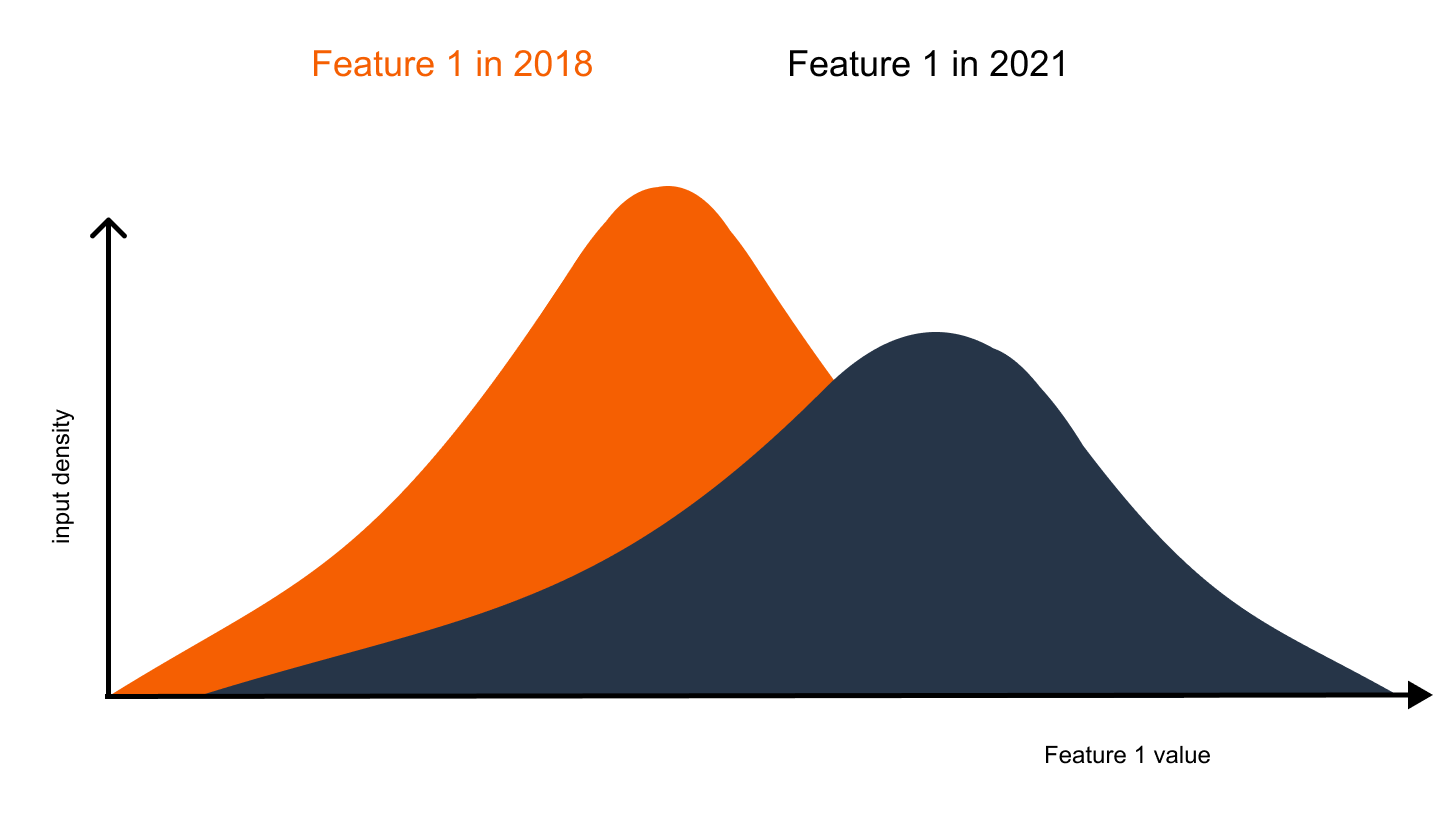
> [image credit](https://ubiops.com/an-introduction-to-model-drift-in-machine-learning/)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# let's download some mock data for this tutorial. Note: this is not the competition dataset!
train_url = 'https://raw.githubusercontent.com/teresadatta100/data-wids-arthur-tutorial/main/wids_sample_train.csv'
test_url = 'https://raw.githubusercontent.com/teresadatta100/data-wids-arthur-tutorial/main/wids_sample_test.csv'


In [ ]:
train_split = pd.read_csv(train_url)
test_split = pd.read_csv(test_url)

In [ ]:
train_split.head()

,Unnamed: 0,lat,lon,start_date,cancm3_0_x,cancm4_0_x,ccsm3_0_x,ccsm4_0_x,cfsv2_0_x,gfdl-flor-a_0_x,...,cancm3_0_y.1,cancm4_0_y.1,ccsm3_0_y.1,ccsm4_0_y.1,cfsv2_0_y.1,gfdl-flor-a_0_y.1,gfdl-flor-b_0_y.1,gfdl_0_y.1,nasa_0_y.1,nmme0_mean_y.1
0,102846,41,251,2016-01-01,-6.956955,-5.249207,-6.963553,-8.85379,-5.483552,-4.61671,...,-3.56669,-3.004288,-3.593095,-2.548514,-1.167208,-1.836101,-1.842291,-1.632294,-0.100628,-2.143456
1,102847,41,251,2016-01-02,-6.956955,-5.249207,-6.963553,-8.85379,-5.483552,-4.61671,...,-3.56669,-3.004288,-3.593095,-2.548514,-1.167208,-1.836101,-1.842291,-1.632294,-0.100628,-2.143456
2,102848,41,251,2016-01-03,-6.956955,-5.249207,-6.963553,-8.85379,-5.483552,-4.61671,...,-3.56669,-3.004288,-3.593095,-2.548514,-1.167208,-1.836101,-1.842291,-1.632294,-0.100628,-2.143456
3,102849,41,251,2016-01-04,-6.956955,-5.249207,-6.963553,-8.85379,-5.483552,-4.61671,...,-3.56669,-3.004288,-3.593095,-2.548514,-1.167208,-1.836101,-1.842291,-1.632294,-0.100628,-2.143456
4,102850,41,251,2016-01-05,-6.956955,-5.249207,-6.963553,-8.85379,-5.483552,-4.61671,...,-3.56669,-3.004288,-3.593095,-2.548514,-1.167208,-1.836101,-1.842291,-1.632294,-0.100628,-2.143456


In [ ]:
test_split.head()

,Unnamed: 0,lat,lon,start_date,cancm3_0_x,cancm4_0_x,ccsm3_0_x,ccsm4_0_x,cfsv2_0_x,gfdl-flor-a_0_x,...,cancm3_0_y.1,cancm4_0_y.1,ccsm3_0_y.1,ccsm4_0_y.1,cfsv2_0_y.1,gfdl-flor-a_0_y.1,gfdl-flor-b_0_y.1,gfdl_0_y.1,nasa_0_y.1,nmme0_mean_y.1
0,103120,41,251,2016-10-01,14.117642,15.467059,14.565073,14.408914,14.4936,14.535936,...,22.556628,23.12348,21.124099,21.493216,20.294103,21.85766,21.655183,21.497983,24.135345,21.970855
1,103121,41,251,2016-10-02,14.117642,15.467059,14.565073,14.408914,14.4936,14.535936,...,22.556628,23.12348,21.124099,21.493216,20.294103,21.85766,21.655183,21.497983,24.135345,21.970855
2,103122,41,251,2016-10-03,14.117642,15.467059,14.565073,14.408914,14.4936,14.535936,...,22.556628,23.12348,21.124099,21.493216,20.294103,21.85766,21.655183,21.497983,24.135345,21.970855
3,103123,41,251,2016-10-04,14.117642,15.467059,14.565073,14.408914,14.4936,14.535936,...,22.556628,23.12348,21.124099,21.493216,20.294103,21.85766,21.655183,21.497983,24.135345,21.970855
4,103124,41,251,2016-10-05,14.117642,15.467059,14.565073,14.408914,14.4936,14.535936,...,22.556628,23.12348,21.124099,21.493216,20.294103,21.85766,21.655183,21.497983,24.135345,21.970855


#🤨 Problem Introduction

Now that we've imported some data, our task is to build a regression model to predict column '**tmp2m**', the average temperature.  Let's take a closer look at the data to understand what we are dealing with. 

Looking at the training data, info() shows us the data type and number of non null values for each column.  All but 1 of the columns are numerical. the 'start_data' column is an object. We'll have to figure out how to deal with this attribute later.

In [ ]:
train_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31784 entries, 0 to 31783
Data columns (total 86 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         31784 non-null  int64  
 1   lat                31784 non-null  int64  
 2   lon                31784 non-null  int64  
 3   start_date         31784 non-null  object 
 4   cancm3_0_x         31784 non-null  float64
 5   cancm4_0_x         31784 non-null  float64
 6   ccsm3_0_x          31784 non-null  float64
 7   ccsm4_0_x          31784 non-null  float64
 8   cfsv2_0_x          31784 non-null  float64
 9   gfdl-flor-a_0_x    31784 non-null  float64
 10  gfdl-flor-b_0_x    31784 non-null  float64
 11  gfdl_0_x           31784 non-null  float64
 12  nasa_0_x           31784 non-null  float64
 13  nmme0_mean_x       31784 non-null  float64
 14  cancm3_x           31784 non-null  float64
 15  cancm4_x           31784 non-null  float64
 16  ccsm3_x            317

We'll start by setting up our X and Y train and test DataFrames so that they are formatted the way we need them.  

For now, we will take a naive approach and use the raw data to train our model.  We'll also drop the 'start_date' column.  By doing this we're skipping some potentially lengthy feature engineering steps, but there are risks to this approach. For one thing, we are failing to take into account certain temporal patterns that may exist in our data which may be important given that this is a time series prediction problem. 

In [ ]:
# Set up train and test DataFrames

# separate tmp2m, the target variable from the features
x_train = train_split.drop(['tmp2m', 'start_date'], axis=1) 
y_train = train_split['tmp2m']
x_test = test_split.drop(['tmp2m', 'start_date'], axis=1).reset_index(drop=True)
y_test = test_split['tmp2m'].reset_index(drop=True)

# 🎨 Exploratory Data Analysis

Before training a model, let's take a few minutes to understand our data.  Since the goal is to create a model that can perform well on unseen data, we will focus our data analysis on the training data, and assume that we don't know what future data (our test data) will look like.

We will start by looking at the distribution of tmp2m, our target variable.

In [ ]:
y_train.describe()

count    31784.000000
mean        11.194868
std          9.435180
min        -20.358963
25%          4.201901
50%         12.428237
75%         19.547122
max         27.648011
Name: tmp2m, dtype: float64

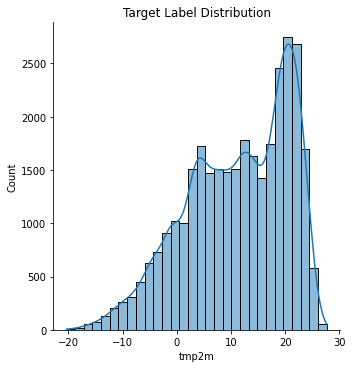

In [ ]:
sns.displot(data=y_train, bins=30, kind='hist', kde=True,).set(title='Target Label Distribution')
plt.show()

Next we'll do the same with our input features. 



In [ ]:
x_train.describe()

,Unnamed: 0,lat,lon,cancm3_0_x,cancm4_0_x,ccsm3_0_x,ccsm4_0_x,cfsv2_0_x,gfdl-flor-a_0_x,gfdl-flor-b_0_x,...,cancm3_0_y.1,cancm4_0_y.1,ccsm3_0_y.1,ccsm4_0_y.1,cfsv2_0_y.1,gfdl-flor-a_0_y.1,gfdl-flor-b_0_y.1,gfdl_0_y.1,nasa_0_y.1,nmme0_mean_y.1
count,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,...,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000,31784.000000
mean,145233.413793,44.905172,256.956897,8.947978,11.886726,8.817273,9.804972,8.718842,9.875028,9.971612,...,7.871546,10.686131,7.746880,8.630983,7.716895,8.835478,8.936994,7.421148,8.785319,8.514597
std,26084.258554,2.576387,3.731085,11.630306,13.424886,10.996844,12.359000,10.445340,11.997953,11.883667,...,11.625289,13.379676,10.971787,12.335892,10.460512,11.908312,11.799842,11.211695,13.780298,11.854500
min,102846.000000,41.000000,251.000000,-12.901797,-13.276428,-9.429795,-11.908517,-10.862477,-12.850254,-10.908525,...,-12.901797,-13.276428,-9.429795,-11.908517,-10.862477,-12.850254,-10.908525,-9.201794,-19.526126,-12.194072
25%,124416.750000,43.000000,254.000000,-1.827853,-0.851236,-2.644975,-2.941202,-1.493918,-0.837373,-0.888307,...,-2.676227,-1.285165,-3.142772,-3.467743,-2.373522,-1.113720,-1.252389,-2.871518,-4.488856,-2.603426
50%,145987.500000,45.000000,257.000000,8.642303,10.319174,8.599659,9.811404,8.359800,8.659911,9.028462,...,4.917682,7.434601,6.142399,8.097714,6.534566,6.197674,6.488242,3.819693,9.165430,6.371841
75%,167192.250000,47.000000,260.000000,21.100974,24.967786,19.828118,21.852499,18.605843,21.424702,21.394111,...,19.780884,24.281268,19.424468,21.201532,18.143154,20.799504,20.519111,18.540955,22.506722,20.838177
max,188031.000000,49.000000,264.000000,28.228564,34.716849,30.520761,28.617416,24.929346,29.858085,29.963088,...,28.228564,34.716849,30.520761,28.617416,24.929346,29.858085,29.963088,34.199637,31.559156,28.873632


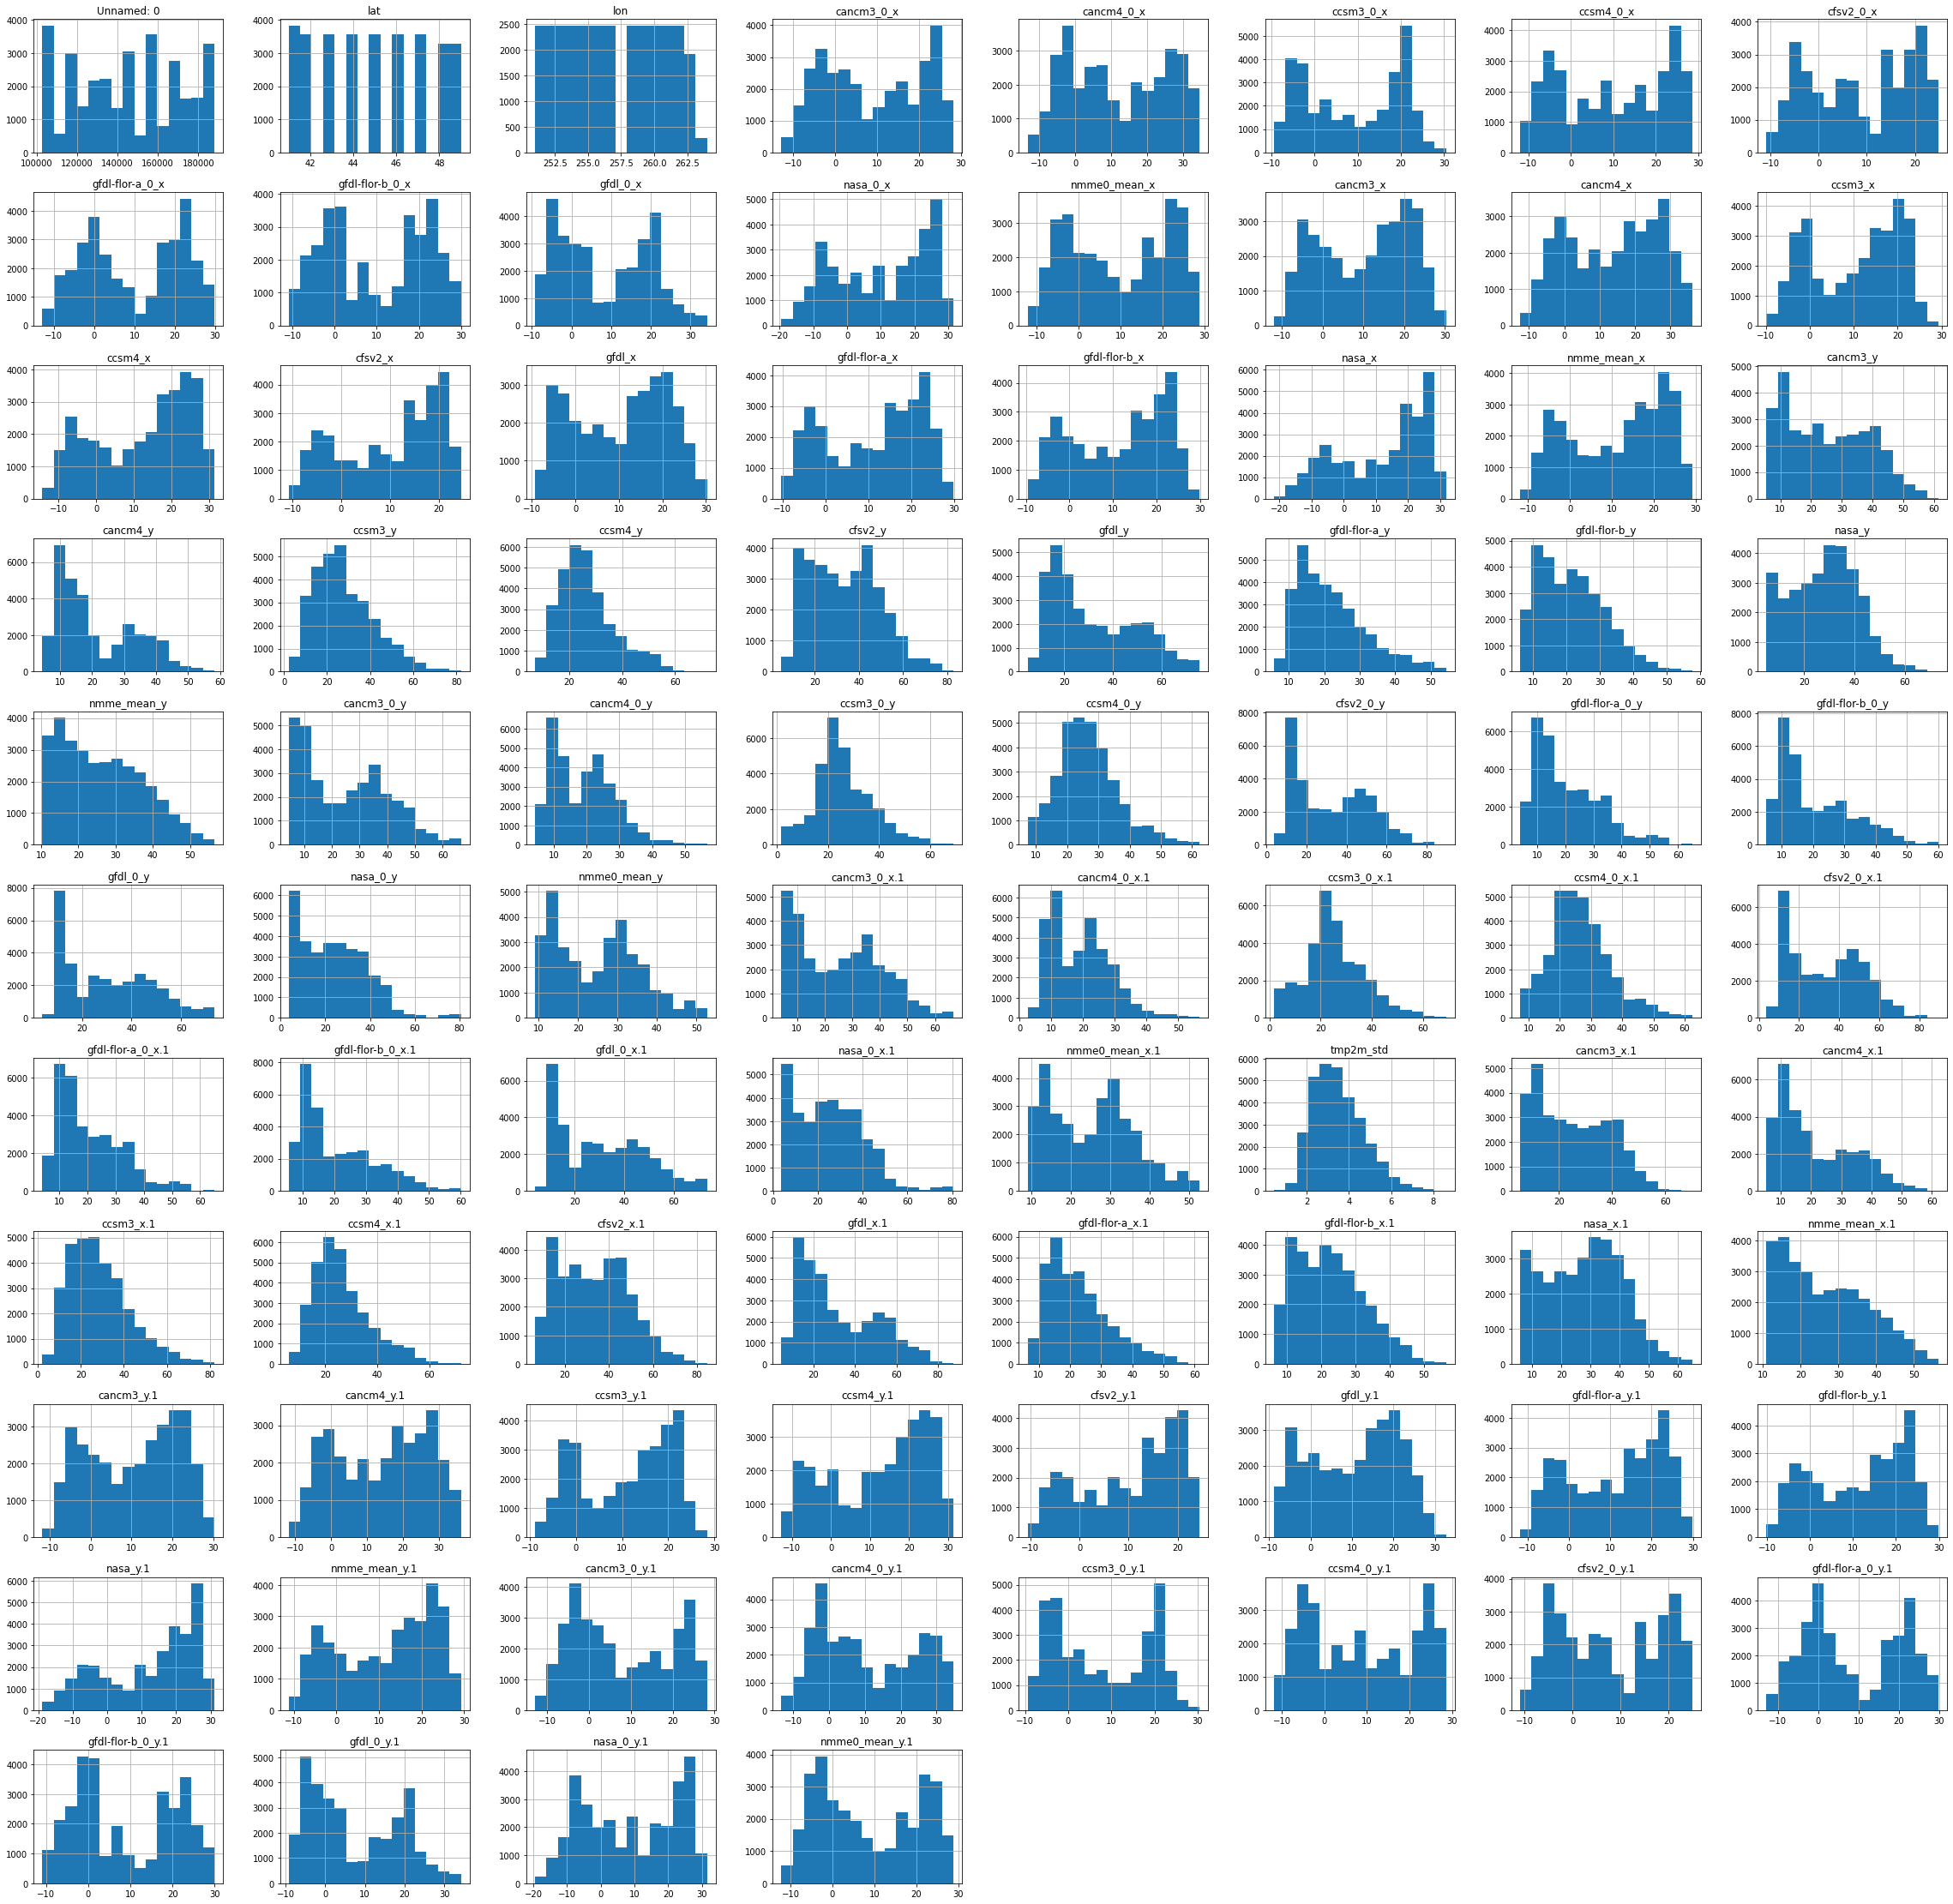

In [ ]:
# This might take a couple of minutes to run - we are generating over 80 plots here!
x_train.hist(bins=15,figsize=(40, 40), layout=(11, 8))
plt.show()

✋ **Note:** Most of our features are not normally distributed, and there are some differences in scaling across the attributes.  While normalized data is not a requirement for most machine learning models, differences in scaling can cause problems. We will use sklearn's StandardScaler to make sure that our features are properly scaled.

# 🚂 Training the Model

In our first attempt, we'll train a Random Forest model. In the next two cells, we'll train the model and then check it's performance on the training and test data.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps = [
               ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor())
           ])

rf_model = pipeline.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import r2_score

train_preds = rf_model.predict(x_train)
train_score = r2_score(y_train, train_preds)

test_preds = rf_model.predict(x_test)
test_score = r2_score(y_test, test_preds)

print (f'Training Performance: {train_score}')
print (f'Test Performance: {test_score}')

Training Performance: 0.9995055064144897
Test Performance: 0.6768633983253628


Taking a look at our model's performance, we can see that it performed very well on the training data, but not so great on the test data.  You may be familiar with this scenario as **overfitting**.  

Let's dig a little bit deeper into what specifically went wrong here.  Overfitting during training is often a result of **data drift**, especially if the model being used is not good at generalizing to new data. Data drift occurs when the unseen test or production data distribution has changed since the model was trained.  Let's look at the distributions of our training data again and see how they compare

Run the next cell to compare the distributions of our target variable.  The **training data** is shown in **blue** and the **test data** is shown in **orange**

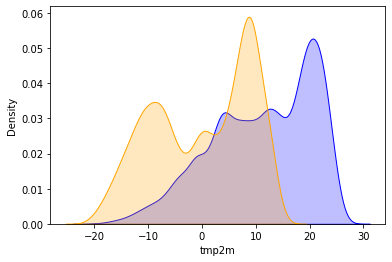

In [ ]:

fig, ax = plt.subplots()
sns.kdeplot(data=y_train,  color='blue', fill=True, ax=ax)
sns.kdeplot(data=y_test, color='orange', fill=True, ax=ax)
plt.show()

From the plot above, it's clear that our label distribution has shifted from the training data to the test data.

Let's compare the training and test distributions of a few of our features.  The function below plots the distributions of a list of 8 features.  Feel free to add to the list to explore more features.  The **training data** is shown in **blue** and the **test data** is shown in **orange**

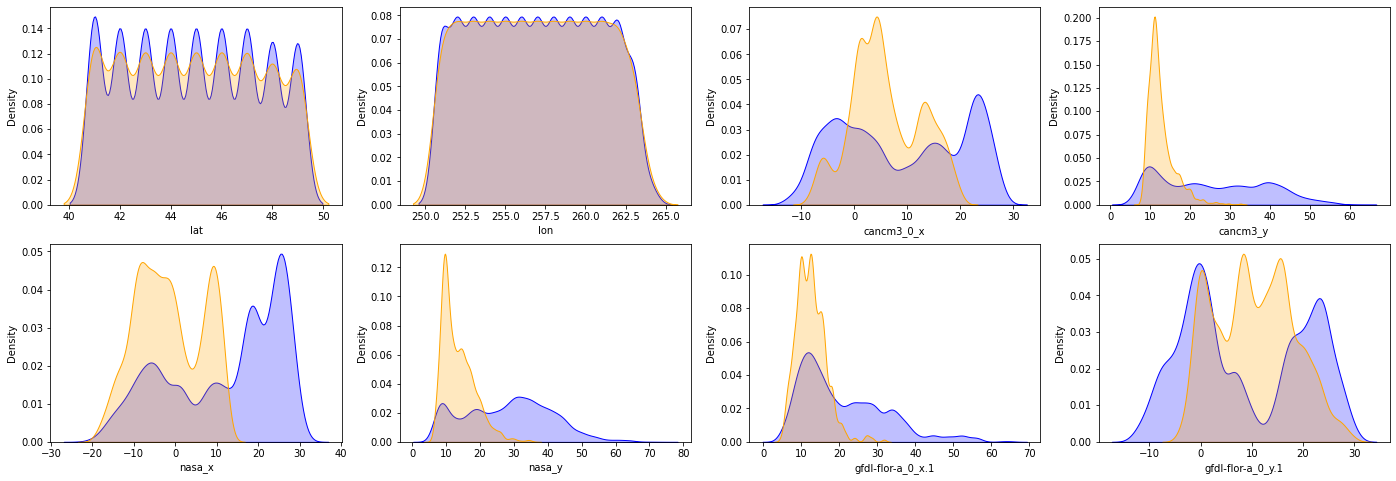

In [ ]:
import math

def show_feature_distributions(features_list):
  width = 4
  height = math.ceil(len(features_list)/width)
  fig, axs = plt.subplots(height, width, figsize=(6*width, 4*height))
  for i, feature in enumerate(features_list):
    ax = axs.flat[i]
    feature = features_list[i]
    sns.kdeplot(data=x_train[feature],  color='blue', fill=True, ax=ax)
    sns.kdeplot(data=x_test[feature], color='orange', fill=True, ax=ax)
  plt.show()


features_list = ['lat', 'lon', 'cancm3_0_x', 'cancm3_y', 'nasa_x', 'nasa_y', 'gfdl-flor-a_0_x.1', 'gfdl-flor-a_0_y.1'	]

show_feature_distributions(features_list)


The feature distribution plots show that many of our features have drifted between the train and test data sets.  The exceptions are the 'lat' and 'lon' features.  This makes sense because these features reference location, which we would not expect to change over time in this data set.  

The distributional changes we have shown here are called **Univariate drift** , meaning that the distributions of individual features have changed over time. 

Data drift is a difficult problem to avoid without regularly retraining your model. One way to reduce the frequency of retraining is to create more of a robust model that can generalize well to new data.  This may require some more sophisticated feature engineering work.

#Feature Engineering

Another way to begin to handle this data drift is to encode aspects of our dropped date columns into new features that we build- a process called feature engineering. Here, we convert our date information to give use the *day of the year, month, and season*.

In [ ]:
def build_date_features(df, ref_set, date_key='start_date'):
  df[date_key] = pd.to_datetime(ref_set[date_key])
  df['day_of_year'] = df[date_key].dt.day_of_year
  df['month'] = df[date_key].dt.month
  df = df.drop([date_key], axis=1) 

build_date_features(x_train, train_split)
build_date_features(x_test, test_split)

In [ ]:
def add_season(df):
  month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
  df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(x_train)
add_season(x_test)

We also take advantage of cyclical feature encoding- sine and cosine encoding this variable to take advantage of the cyclical nature of a year's time period. 

In [ ]:
## https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
def encode_cyclical(df):
  # encode the day with a period of 365
  df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
  df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])

  # encode the month with a period of 12
  df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
  df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

  # encode the season with a period of 4
  df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
  df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(x_train)
encode_cyclical(x_test)

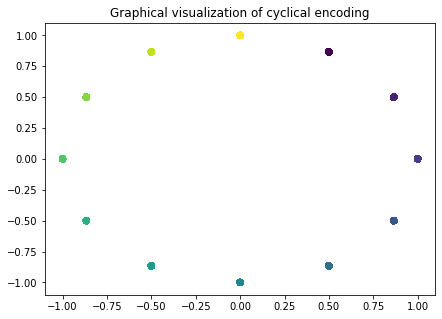

In [ ]:
all_data = pd.concat([x_train, x_test])
fig, ax = plt.subplots(figsize=(7, 5))
plt.title("Graphical visualization of cyclical encoding")
ax.scatter(all_data["month_sin"], all_data["month_cos"], c=all_data["month"])


# Feature Selection 

We are going to look at two key techniques for selecting important features for the model. The first is correlation and second is feature importance. 

### Correlation 

It is typically recommended to remove highly correlated variables when building out ML models. This is not only because there are specific model architectures that perform poorly under multicollinearity, but also because highly correlated variables have been shown to introduce higher risk of errrors. This is because having many correlated variables increases the complexity of your model without introducing a lot of additional, new information. 

In [ ]:
print(len(x_train.columns))

94


One of the most common ways for people to check for correlation features is to visualize your feature space with a heatmap. However, with this many features we can see that a heatmap can be a bit overwhelming. 

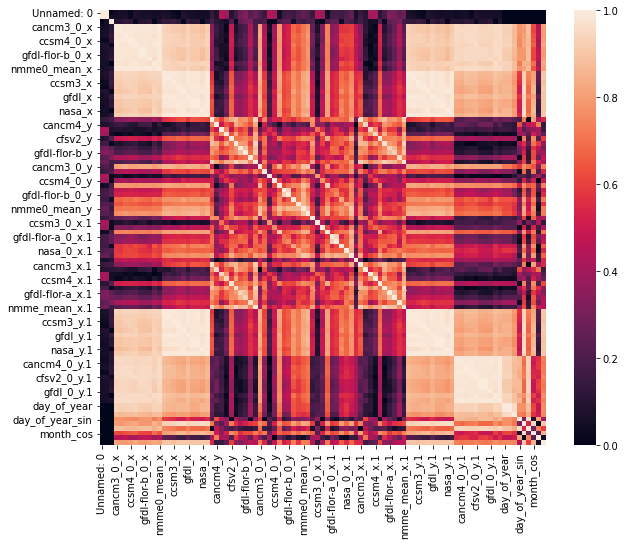

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
matrix = x_train.corr().abs()

plt.figure(figsize=(10,8))
_ = sns.heatmap(matrix)

From this heatmap, we can see there are large sections of highly correlated features. However, it may be difficult to remove highly correlated features visually. So instead, we are going to use a common method to identify highly correlated features and remove them from our dataset. 

This method utilizes the correlation matrix that we saw in the heatmap above. We can see in that plot that the heatmap is actually symmetrical across the diagonal. So, we are able to actually mask the correlation matrix on upper triangle and use our reduced correlation matrix to find correlations that are too high, as determined by our designated threshold. 

In [ ]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [ ]:
# separate tmp2m, the target variable from the features
x_train = train_split.drop(['tmp2m', 'start_date'], axis=1) 
y_train = train_split['tmp2m']
x_test = test_split.drop(['tmp2m', 'start_date'], axis=1).reset_index(drop=True)
y_test = test_split['tmp2m'].reset_index(drop=True)

In [ ]:
print(len(x_train.columns))

84


In [ ]:
## Get the column names to drop 
to_drop = identify_correlated(x_train, threshold=.96)

In [ ]:
x_train_reduced = pd.DataFrame(x_train.drop(to_drop, axis=1))

In [ ]:
print(len(x_train_reduced.columns))

41


As we can see, we dropped 45 highly correlated features from our training dataset. 

In [ ]:
x_test_reduced = pd.DataFrame(x_test.drop(to_drop, axis=1))
print(len(x_test_reduced.columns))

41


In [ ]:
pipeline = Pipeline(steps = [
              ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor())
           ])

rf_model2 = pipeline.fit(x_train_reduced, y_train)

train_preds = rf_model2.predict(x_train_reduced)
train_score = r2_score(y_train, train_preds)

test_preds = rf_model2.predict(x_test_reduced)
test_score = r2_score(y_test, test_preds)

print (f'Training Performance: {train_score}')
print (f'Test Performance: {test_score}')

Training Performance: 0.9993036110802138
Test Performance: 0.7175495406702349


Here we can see an improved training performance than what we ran above. 

## Feature Importance 

Another common feature selection technique can be done utilizing feature importance. It works in a very similar way to correlation searching for features that are adding more noise than additional information. As we saw before, when using correlation to search for noise, we are searching for noise that is brought on by having many variables giving the same information. 

However, when we choose to use Feature Importance, we are not actually comparing the features to each other. Instead, we are looking at each of the features independently and evaluating how useful each feature is to solving the actual problem. It does this by evaluating how important each feature is to driving the prediction the model makes. We can use these importance scores in feature selection to remove any features that do little to drive model predictions and instead only add noise to our models. 

### Feature Importance Technique : Random Forest Regressor

We are first going to look at feature importance using one of the most common techniques (which is incidentally one that we have been using) - the Random Forest Regressor. Random Forest models are able to generate feature importance scores by calculating node impurity and probability of reaching that node at each of the model's decision points. Many teams will utilize random forest models to evaluate feature importane for feature selection, even if they are going to use a more advanced architecture for their actual modeling. 

In [ ]:
importances = rf_model2.steps[1][1].feature_importances_

<BarContainer object of 41 artists>

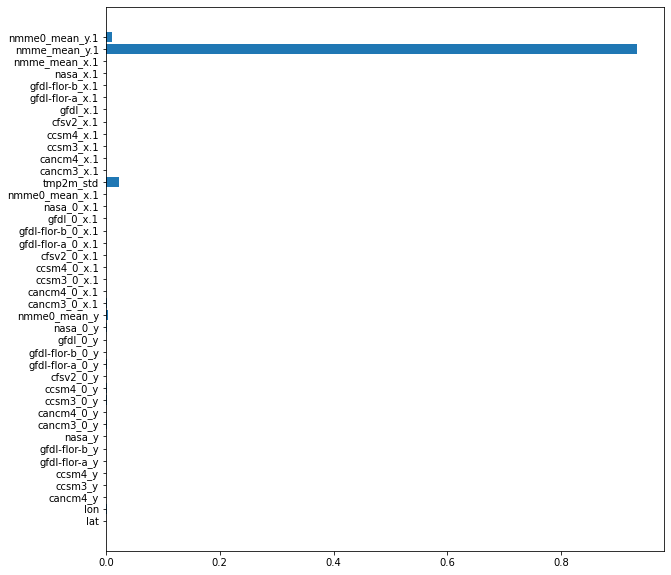

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(x_train_reduced.columns, importances, height = .8)


We can see that there are very few important features. Based on this plot, we think that it would be interesting to see if pruning our model for a small number of the most important features would lead to improvements in our model. To do this, we can use the common Recursive Feature Extraction using Cross Validation. 

### Recursive Feature Extraction using Cross Validation 

RFECV works to prune features from the model utilizing feature importance scores. Every step it removes the least important features (number of features removed is determined by the step) and evaluates whether or not that provided an increase in accuracy for the model. An important difference between this technique and typical recursive feature extraction is that this technique uses cross validation. In the example below, we specify 3 meaning that a 3 fold cross validation occurs with each evaluation to help validate that the removal of features was not justified just by the sample taken. 

A great resouce for machine learning content is the machine learning mastery blog. Here are two additional resources on both feature extraction and K-Fold cross validation. 
* More information about Feature Extraction: https://machinelearningmastery.com/rfe-feature-selection-in-python/#:~:text=Technically%2C%20RFE%20is%20a%20wrapper,until%20the%20desired%20number%20remains. 
* More information about K Fold Cross Validation: https://machinelearningmastery.com/k-fold-cross-validation/ 

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

from sklearn.feature_selection import RFECV
estimator = RandomForestRegressor()
selector = RFECV(estimator, step=8, cv=3)
selector = selector.fit(x_train_reduced, y_train)

We can use this to find the features that our recursive technique considers to be important. We can see the features ranked below:

In [ ]:
print("Feature ranking: ", selector.ranking_)

Feature ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 2 1 2 2 1 1 1 1 1 2 1 1 1
 1 2 1 1]


In [ ]:
## Get features marked as important (or to keep) by RFECV

mask = selector.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True])

In [ ]:
features = np.array(x_train_reduced.columns)
best_features = features[mask]

In [ ]:
best_features

array(['lat', 'lon', 'cancm4_y', 'ccsm3_y', 'ccsm4_y', 'gfdl-flor-a_y',
       'gfdl-flor-b_y', 'nasa_y', 'cancm3_0_y', 'cancm4_0_y', 'ccsm3_0_y',
       'ccsm4_0_y', 'cfsv2_0_y', 'gfdl-flor-a_0_y', 'gfdl_0_y',
       'nasa_0_y', 'nmme0_mean_y', 'cancm3_0_x.1', 'cancm4_0_x.1',
       'ccsm3_0_x.1', 'gfdl-flor-a_0_x.1', 'gfdl_0_x.1', 'tmp2m_std',
       'cancm3_x.1', 'cancm4_x.1', 'ccsm3_x.1', 'ccsm4_x.1', 'gfdl_x.1',
       'gfdl-flor-a_x.1', 'gfdl-flor-b_x.1', 'nasa_x.1', 'nmme_mean_y.1',
       'nmme0_mean_y.1'], dtype=object)

In [ ]:
x_train_reduced_import_ft = x_train_reduced[best_features]
x_test_reduced_import_ft = x_test_reduced[best_features]


pipeline = Pipeline(steps = [
              ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor())
           ])

rf_model2 = pipeline.fit(x_train_reduced_import_ft, y_train)

train_preds = rf_model2.predict(x_train_reduced_import_ft)
train_score = r2_score(y_train, train_preds)

test_preds = rf_model2.predict(x_test_reduced_import_ft)
test_score = r2_score(y_test, test_preds)

print (f'Training Performance: {train_score}')
print (f'Test Performance: {test_score}')

Training Performance: 0.9992928463323676
Test Performance: 0.7208997117668368


With this we can see continues improvement in our model. 